In [320]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score ,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE


### Part 1 - Predictive Modelling (Binary Classification)

#### Loading Data

In [39]:
df = pd.read_csv("Assignment_Data.csv")

#### Data Summary and Missing value check

In [72]:
print(df.shape)
df.info()

# Target distribution
print(df['readmitted_30_days'].value_counts(normalize=True))

# Check missing values - NULL VALUE CHECK
df.isnull().sum()

# Look at the object (categorical) columns
df.select_dtypes(include='object').nunique()

(200, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               200 non-null    int64 
 1   age                      200 non-null    int64 
 2   gender                   200 non-null    object
 3   diagnosis_code           200 non-null    object
 4   num_previous_admissions  200 non-null    int64 
 5   medication_type          200 non-null    object
 6   length_of_stay           200 non-null    int64 
 7   readmitted_30_days       200 non-null    int64 
 8   discharge_note           200 non-null    object
dtypes: int64(5), object(4)
memory usage: 14.2+ KB
readmitted_30_days
0    0.675
1    0.325
Name: proportion, dtype: float64


gender              2
diagnosis_code      4
medication_type     3
discharge_note     10
dtype: int64

#### Data Cleaning 
- Drop unnecessary columns
- Adding features
- one hot encoding

In [89]:
# Drop unnecessary columns
df_clean = df.drop(['patient_id', 'discharge_note'], axis=1)

#New feature

df_clean['high_risk_flag'] = ((df_clean['num_previous_admissions'] > 2) & 
                              (df_clean['length_of_stay'] > 7)).astype(int)

df_clean['prev_adm_group'] = pd.cut(df_clean['num_previous_admissions'], 
                                     bins=[-1, 0, 2, np.inf], 
                                     labels=['None', 'Low', 'High'])

df_clean['prev_adm_group'] = df_clean['prev_adm_group'].astype(str)
# Encode categorical columns
categorical_cols = df_clean.select_dtypes(include='object').columns
df_updated = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)
df_updated.dtypes

age                        int64
num_previous_admissions    int64
length_of_stay             int64
readmitted_30_days         int64
high_risk_flag             int64
gender_Male                 bool
diagnosis_code_D002         bool
diagnosis_code_D003         bool
diagnosis_code_D004         bool
medication_type_Type B      bool
medication_type_Type C      bool
prev_adm_group_Low          bool
prev_adm_group_None         bool
dtype: object

#### Exploratory Data Analysis (EDA)
- Compared readmission patterns across gender and medication types
- Reviewed age distribution
- Correlation Matrix


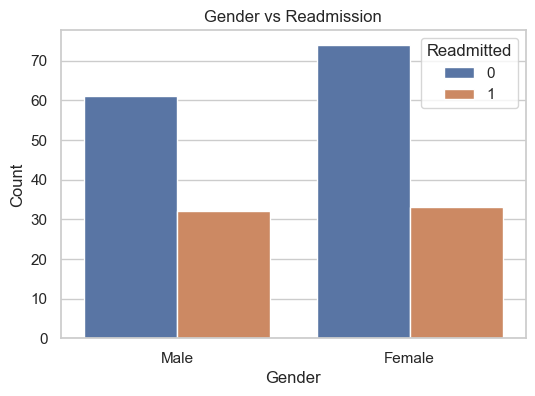

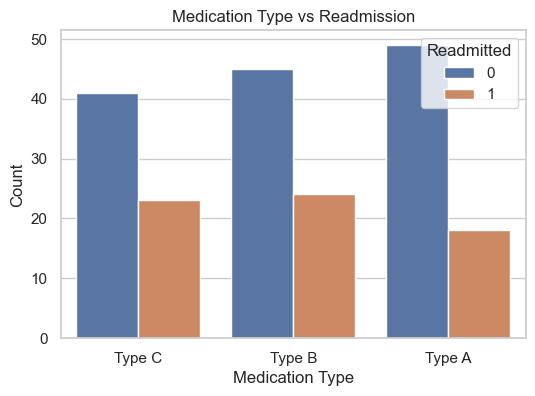

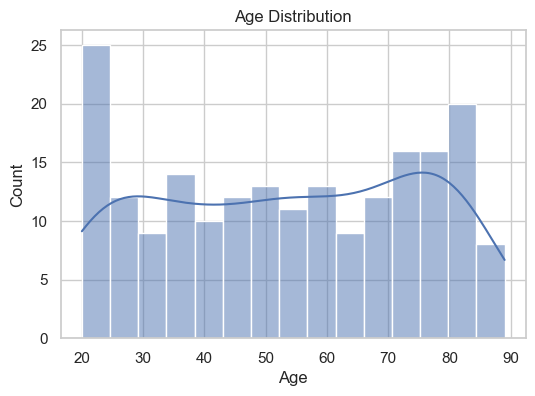

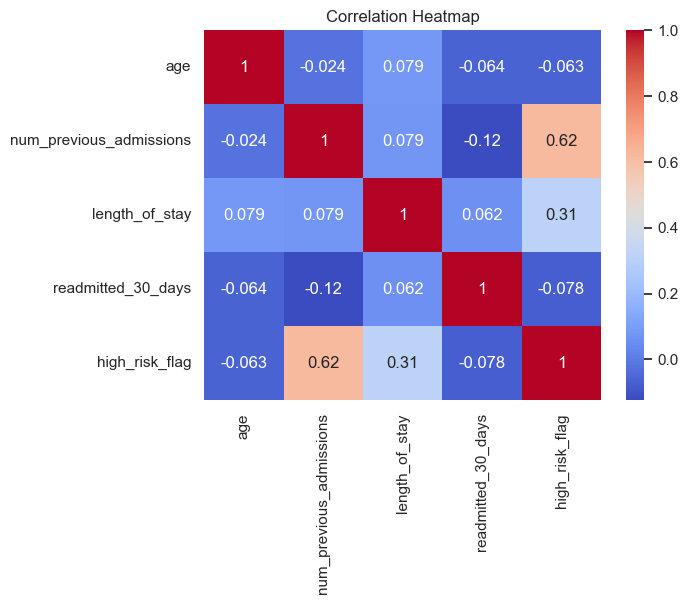

In [90]:

# Set plot style
sns.set(style="whitegrid")

# 1. Gender vs Target
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', hue='readmitted_30_days', data=df)
plt.title("Gender vs Readmission")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title='Readmitted')
plt.show()

# 2. Medication Type vs Target
plt.figure(figsize=(6, 4))
sns.countplot(x='medication_type', hue='readmitted_30_days', data=df)
plt.title("Medication Type vs Readmission")
plt.xlabel("Medication Type")
plt.ylabel("Count")
plt.legend(title='Readmitted')
plt.show()

# 3. Age distribution
plt.figure(figsize=(6, 4))
sns.histplot(df['age'], bins=15, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

numeric_cols = ['age', 'num_previous_admissions', 'length_of_stay', 'readmitted_30_days','high_risk_flag']

# Correlation matrix
correlation = df_clean[numeric_cols].corr()


import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [91]:
X = df_updated.drop('readmitted_30_days', axis=1)
y = df_updated['readmitted_30_days']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
df_updated = df.drop(['high_risk_flag'], axis=1)

In [ ]:
Train and Test split

In [92]:
#Feature Scalig
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Model Training â€” Random Forest (Model 1)

In [116]:
df_updated=df_updated.drop(['high_risk_flag','prev_adm_group_Low','prev_adm_group_None'], axis=1)

### Train and Test Split

In [117]:
X = df_updated.drop('readmitted_30_days', axis=1)
y = df_updated['readmitted_30_days']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [118]:
#Feature Scalig
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [119]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

In [120]:
print("Confusion Matrix:", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:", classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))

Confusion Matrix: [[20  7]
 [11  2]]
Classification Report:               precision    recall  f1-score   support

           0       0.65      0.74      0.69        27
           1       0.22      0.15      0.18        13

    accuracy                           0.55        40
   macro avg       0.43      0.45      0.44        40
weighted avg       0.51      0.55      0.52        40

ROC AUC Score: 0.4472934472934472
F1 Score: 0.18181818181818182


#### Feature Importance

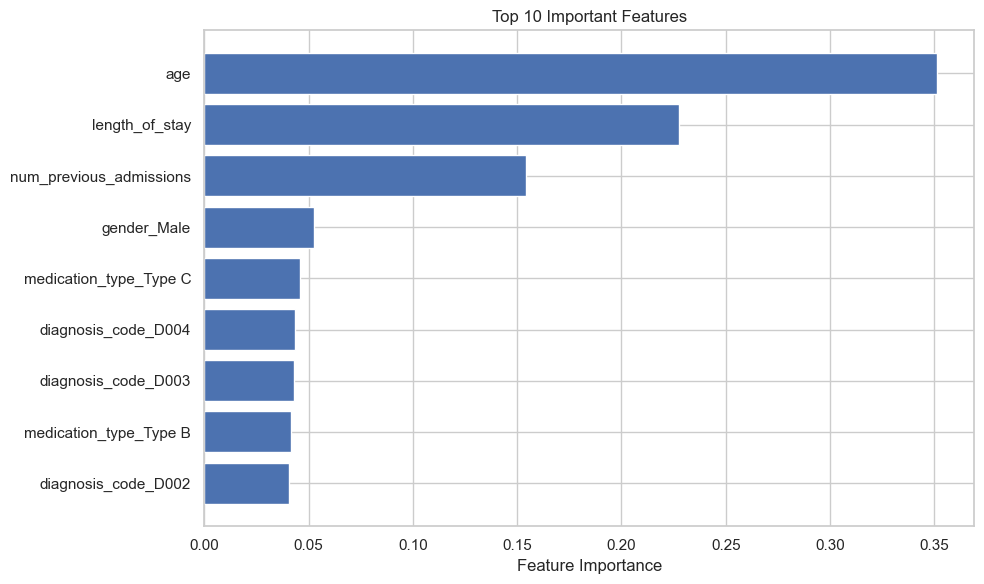

In [121]:
importances = rf_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10,6))
plt.title('Top 10 Important Features')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

#### Smote For imbalance data

In [122]:

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# RF on Smote Data
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)


y_pred_rf_smote = rf.predict(X_test_scaled)
y_proba_rf_smote = rf.predict_proba(X_test_scaled)[:, 1]


print("Confusion Matrix:", confusion_matrix(y_test, y_pred_rf_smote))
print("Classification Report:", classification_report(y_test, y_pred_rf_smote))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_rf_smote))
print("F1 Score:", f1_score(y_test, y_pred_rf_smote))

Confusion Matrix: [[17 10]
 [10  3]]
Classification Report:               precision    recall  f1-score   support

           0       0.63      0.63      0.63        27
           1       0.23      0.23      0.23        13

    accuracy                           0.50        40
   macro avg       0.43      0.43      0.43        40
weighted avg       0.50      0.50      0.50        40

ROC AUC Score: 0.43019943019943024
F1 Score: 0.23076923076923078


#### Logistic Regression - Model 2

In [123]:

logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)

#predict
y_pred_log = logreg.predict(X_test_scaled)
y_proba_log = logreg.predict_proba(X_test_scaled)[:, 1]

#Evaluation Metrics
print("Confusion Matrix", confusion_matrix(y_test, y_pred_log))
print("Classification Report", classification_report(y_test, y_pred_log))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_log))
print("F1 Score:", f1_score(y_test, y_pred_log))

Confusion Matrix [[ 8 19]
 [ 6  7]]
Classification Report               precision    recall  f1-score   support

           0       0.57      0.30      0.39        27
           1       0.27      0.54      0.36        13

    accuracy                           0.38        40
   macro avg       0.42      0.42      0.37        40
weighted avg       0.47      0.38      0.38        40

ROC AUC Score: 0.41737891737891736
F1 Score: 0.358974358974359


#### Evaluation Summary

In [125]:
# #AUC curvec
# auc = roc_auc_score(y_test, y_proba_rf)
# print(f"ROC AUC Score: {auc:.2f}")


# fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)

# # 3. Plot the ROC curve
# plt.figure(figsize=(6, 4))
# plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}", color='blue')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # baseline
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve")
# plt.legend()
# plt.grid(True)
# plt.show()


In [124]:
# creating dictionary
summary = {
    "Model": ["Random Forest", "Random Forest + SMOTE", "Logistic Regression"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_rf_smote),
        accuracy_score(y_test, y_pred_log)
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_rf),
        f1_score(y_test, y_pred_rf_smote),
        f1_score(y_test, y_pred_log)
    ],
    "Recall": [
        recall_score(y_test, y_pred_rf),
        recall_score(y_test, y_pred_rf_smote),
        recall_score(y_test, y_pred_log)
    ],
    "Precision": [
        precision_score(y_test, y_pred_rf),
        precision_score(y_test, y_pred_rf_smote),
        precision_score(y_test, y_pred_log)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_proba_rf),
        roc_auc_score(y_test, y_proba_rf_smote),
        roc_auc_score(y_test, y_proba_log)
    ]
}

# Convert to DataFrame
summary_df = pd.DataFrame(summary)
summary_df.round(3)  # Optional: round metrics to 3 decimal places


Model  Accuracy  F1 Score  Recall  Precision  ROC AUC
0          Random Forest     0.550     0.182   0.154      0.222    0.467
1  Random Forest + SMOTE     0.500     0.231   0.231      0.231    0.442
2    Logistic Regression     0.375     0.359   0.538      0.269    0.376

## PART 2 - Named EnAty RecogniAon from Discharge Notes (LLM/NLP)

In [219]:
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !pip install transformers sentencepiece
#!pip install torch

In [321]:
#loading revelant packages
import spacy
from transformers import pipeline
import pandas as pd

#### Loading data and Model 

#### NER using Spacy

In [330]:
Load model and data
nlp = spacy.load("en_core_web_sm")
df = pd.read_csv("Assignment_Data.csv")

# Function to extract entities from discharge notes
def extract_entities(text):
    doc = nlp(str(text))
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply extraction
df['extracted_entities'] = df['discharge_note'].apply(extract_entities)

# Display a few examples
df[['discharge_note', 'extracted_entities']].head(3)

### Biomedical NER Model

In [334]:
df = pd.read_csv("Assignment_Data.csv")

##### Creating Pipeline

In [332]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

# Load a biomedical NER model
model_name = "d4data/biomedical-ner-all"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)


ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")


Device set to use mps:0


In [340]:
#function takes a discharge note as input and extracts medical entities using a pretrained biomedical NER model.

def extract_with_biomedical_ner(note):
    try:
        ner_results = ner_pipeline(note)
        return [(entity["word"], entity["entity_group"]) for entity in ner_results]
    except Exception as e:
        return f"Error: {str(e)}"


#### Extracing 

In [339]:
df["bio_ner_output"] = df["discharge_note"].dropna().apply(extract_with_biomedical_ner)
df["bio_ner_output"].head(100)

0                                                    []
1                                 [(stable, Lab_value)]
2     [(symptoms, Sign_symptom), (re, Therapeutic_pr...
3                                 [(stable, Lab_value)]
4                                 [(stable, Lab_value)]
                            ...                        
95    [(normal, Lab_value), (diet, Diagnostic_proced...
96    [(symptoms, Sign_symptom), (re, Therapeutic_pr...
97    [(symptoms, Sign_symptom), (re, Therapeutic_pr...
98    [(symptoms, Sign_symptom), (re, Therapeutic_pr...
99    [(discharged, Clinical_event), (stable, Lab_va...
Name: bio_ner_output, Length: 100, dtype: object

In [327]:
from collections import defaultdict

# Step 1: Label mapping
entity_map = {
    "Disease": "DIAGNOSIS",
    "Sign_symptom": "SYMPTOM",
    "Severity": "SYMPTOM",
    "Medication": "MEDICATION",
    "Therapeutic_procedure": "TREATMENT",
    "Diagnostic_procedure": "TREATMENT",
    "Clinical_event": "FOLLOWUP",
    "Duration": "FOLLOWUP"
}

assignment_categories = set(entity_map.values())

# Step 2: Add empty assignment columns
for cat in assignment_categories:
    df[cat] = ""

# Step 3: Apply function
def extract_assignment_entities(row):
    entity_data = row["bio_ner_output"]
    if not isinstance(entity_data, list):
        return row
    
    bucket = defaultdict(list)
    
    for word, label in entity_data:
        word = str(word).strip(",. ").lower()
        if label in entity_map:
            bucket[entity_map[label]].append(word)
    
    for cat in assignment_categories:
        row[cat] = ", ".join(sorted(set(bucket[cat])))

    return row

# Apply to whole DataFrame
df_final = df.apply(extract_assignment_entities, axis=1)


In [328]:
df_final.to_csv("output.csv")

In [329]:
df_final.head(10)

patient_id  age  gender diagnosis_code  num_previous_admissions  \
0           1   71    Male           D002                        3   
1           2   34  Female           D002                        1   
2           3   80    Male           D002                        2   
3           4   40  Female           D002                        2   
4           5   43  Female           D001                        1   
5           6   22  Female           D004                        1   
6           7   41    Male           D002                        1   
7           8   72    Male           D002                        0   
8           9   21  Female           D003                        4   
9          10   49    Male           D002                        2   

  medication_type  length_of_stay  readmitted_30_days  \
0          Type C               2                   0   
1          Type B               3                   1   
2          Type C               5                   1   
3          Type C              11                   0   
4          Type C               8                   1   
5          Type A              10                   1   
6          Type A               7                   1   
7          Type B               7                   1   
8          Type B              12                   0   
9          Type A               7                   0   

                                      discharge_note  \
0  Good recovery trajectory. Follow-up scan sched...   
1  Stable post-surgery. Advised to avoid physical...   
2  Symptoms controlled. Monitoring for relapse ad...   
3  Stable post-surgery. Advised to avoid physical...   
4  Stable post-surgery. Advised to avoid physical...   
5  Good recovery trajectory. Follow-up scan sched...   
6  Discharge after recovery from pneumonia. No co...   
7  Patient discharged in stable condition. Recomm...   
8  Patient showed improvement. Prescribed antibio...   
9  Blood pressure under control. Continue current...   

                                      bio_ner_output DIAGNOSIS  \
0                                                 []             
1                              [(stable, Lab_value)]             
2  [(symptoms, Sign_symptom), (re, Therapeutic_pr...             
3                              [(stable, Lab_value)]             
4                              [(stable, Lab_value)]             
5                                                 []             
6  [(discharge, Clinical_event), (complications, ...             
7  [(discharged, Clinical_event), (stable, Lab_va...             
8         [(antibiotics, Medication), (5, Duration)]             
9           [(blood pressure, Diagnostic_procedure)]             

        TREATMENT            FOLLOWUP   SYMPTOM   MEDICATION  
0                                                             
1                                                             
2     ##lapse, re                      symptoms               
3                                                             
4                                                             
5                                                             
6                           discharge                         
7                  discharged, follow                         
8                                   5            antibiotics  
9  blood pressure